In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import preprocessing
import imblearn
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [9]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [10]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [12]:
def check_nan(col_name):
  print(df[col_name].isnull().values.any())

In [13]:
for col in df.columns:
  check_nan(col)

False
False
False
False
False
False
False
False
False


In [14]:
# df.dropna(inplace=True)
# print(df)

In [15]:
df.groupby('smoking_history').size()

smoking_history
No Info        35816
current         9286
ever            4004
former          9352
never          35095
not current     6447
dtype: int64

<Axes: xlabel='diabetes', ylabel='count'>

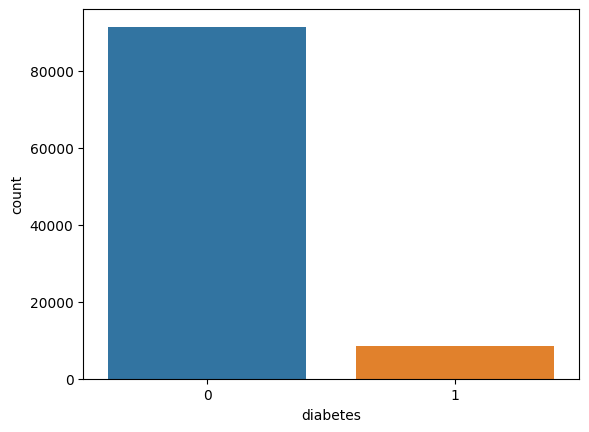

In [16]:
sns.countplot(x=df['diabetes'])

<Axes: >

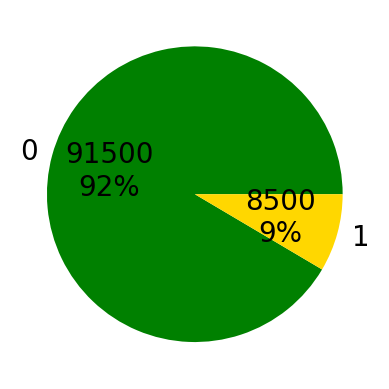

In [17]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

df.groupby('diabetes').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 20},
                                  colors=['green', 'gold'])

Clearly there is an imbalance in the dataset with a fewer number of patients with diabetes.

Text(0, 0.5, 'Frequency')

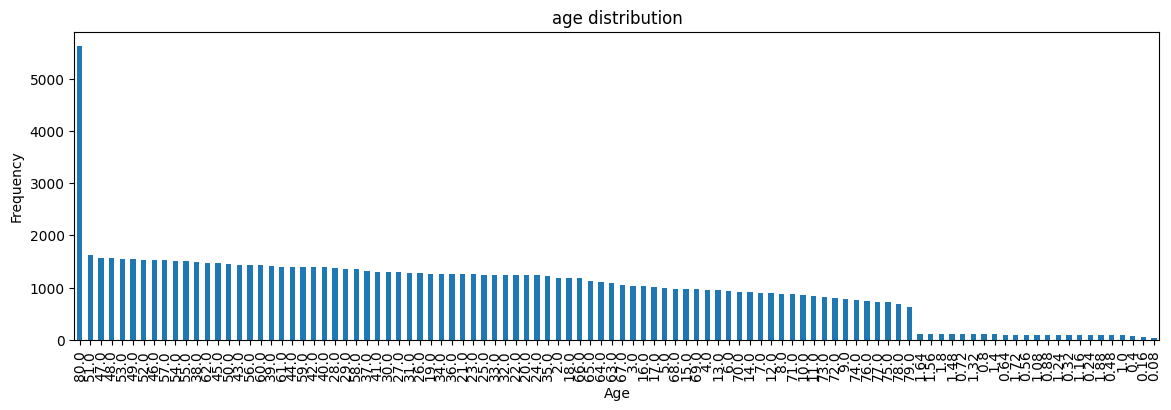

In [18]:
ax = df['age'].value_counts().plot(kind='bar',
                                    figsize=(14, 4),
                                    title="age distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")

There is also an over representation of patients with the age 80.

<Axes: >

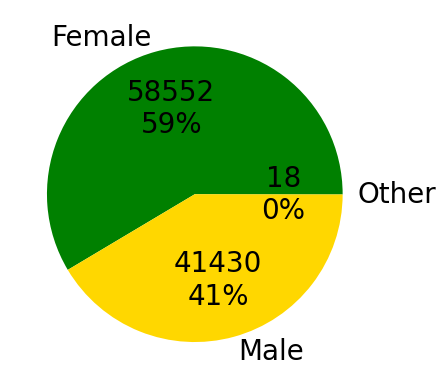

In [19]:
df.groupby('gender').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 20},
                                  colors=['green', 'gold'])

Since we have very few instances of OTHER in gender type, we are going to drop the corresponding rows.

In [20]:
df.drop(df[df['gender']=="Other"].index,inplace=True)
df.reset_index(drop=True,inplace=True)


<Axes: >

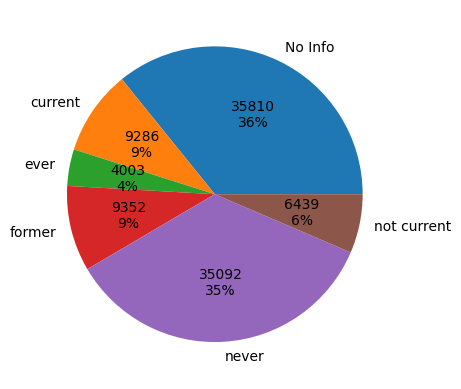

In [21]:
df.groupby('smoking_history').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 10})

for a large proportion of people info about their smoking history is not available



Let us observe the results on using logistic regression without any further changes

In [22]:
#encoding categorical variables (gender and smoking history) using get_dummies.
df = pd.get_dummies(df, columns=["gender", "smoking_history"], prefix=["gender_is", "sh_"] )

In [23]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_is_Female,gender_is_Male,sh__No Info,sh__current,sh__ever,sh__former,sh__never,sh__not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,1,0,0,0,0


In [24]:
df = df[[c for c in df if c != 'diabetes']
       + ['diabetes']]

In [25]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_is_Female,gender_is_Male,sh__No Info,sh__current,sh__ever,sh__former,sh__never,sh__not current,diabetes
0,80.0,0,1,25.19,6.6,140,1,0,0,0,0,0,1,0,0
1,54.0,0,0,27.32,6.6,80,1,0,1,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0,0
3,36.0,0,0,23.45,5.0,155,1,0,0,1,0,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0,0


In [26]:
print(len(df.columns))

15


In [27]:
# def check_nan(col_name):
#   print(df[col_name].isnull().values.any())

# for col in df.columns:
#   check_nan(col)

In [28]:
DF = df.copy()
scaled = preprocessing.StandardScaler()
new = scaled.fit_transform(DF.drop(columns='diabetes'))
DFs = pd.DataFrame(new,columns = list(DF.drop(columns='diabetes')))
DFs['diabetes'] = DF['diabetes']
df = DFs

In [29]:
# DFs.head()

In [30]:
# DFs.columns

In [31]:
# def check_nan(col_name):
#   print(DFs[col_name].isnull().values.any())

# for col in DFs.columns:
#   check_nan(col)

In [32]:
print(DFs[DFs['diabetes'].isnull()==True].size)

0


In [33]:
# df.dropna(inplace=True)
# print(df)

In [34]:
# def check_nan(col_name):
#   print(df[col_name].isnull().values.any())

# for col in df.columns:
#   check_nan(col)

In [35]:
x= df.iloc[:,0:13].values
y= df.iloc[:, 14].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(x_train, y_train)
# Prediction
y_pred = clf.predict(x_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc*100)

Logistic Regression model accuracy (in %): 96.01151689649947


In [36]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30130
           1       0.87      0.63      0.73      2865

    accuracy                           0.96     32995
   macro avg       0.92      0.81      0.86     32995
weighted avg       0.96      0.96      0.96     32995



Let us use some oversampling methods and compare results.

In [37]:
#Random Oversampling
random_os = RandomOverSampler(random_state = 42)
X_random, y_random = random_os.fit_resample(x_train, y_train)
#SMOTE
smote_os = SMOTE(random_state = 42)
X_smote, y_smote = smote_os.fit_resample(x_train, y_train)
#BorderlineSMOTE
smote_border = BorderlineSMOTE(random_state = 42, kind = 'borderline-2')
X_smoteborder, y_smoteborder = smote_border.fit_resample(x_train, y_train)
#SVM SMOTE
smote_svm = SVMSMOTE(random_state = 42)
X_smotesvm, y_smotesvm = smote_svm.fit_resample(x_train, y_train)
# #K-Means SMOTE
smote_kmeans = KMeansSMOTE(cluster_balance_threshold=0.1)
X_smotekmeans, y_smotekmeans = smote_kmeans.fit_resample(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [38]:
comparison_sets = [(x_train, y_train), (X_random, y_random), (X_smote, y_smote), (X_smoteborder, y_smoteborder), (X_smotesvm, y_smotesvm), (X_smotekmeans, y_smotekmeans)]
recalls = []
methods = ['No oversampling', 'Random OS', 'SMOTE OS', 'Borderline SMOTE', 'SVM SMOTE', 'K-Means SMOTE']


In [39]:
# model = LogisticRegression()
# model.fit(x_train,y_train)
rf = RandomForestClassifier(random_state = 42, max_depth = 5)
for i in range(0, len(comparison_sets)):
  print(methods[i])
  rf.fit(comparison_sets[i][0], comparison_sets[i][1])
  # model.fit(comparison_sets[i][0], comparison_sets[i][1])
  print(classification_report(y_test, rf.predict(x_test)))

No oversampling
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     30130
           1       1.00      0.67      0.80      2865

    accuracy                           0.97     32995
   macro avg       0.98      0.83      0.89     32995
weighted avg       0.97      0.97      0.97     32995

Random OS
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     30130
           1       0.51      0.88      0.65      2865

    accuracy                           0.92     32995
   macro avg       0.75      0.90      0.80     32995
weighted avg       0.95      0.92      0.93     32995

SMOTE OS
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     30130
           1       0.53      0.87      0.66      2865

    accuracy                           0.92     32995
   macro avg       0.76      0.90      0.81     32995
weighted avg       0.95      0.92      

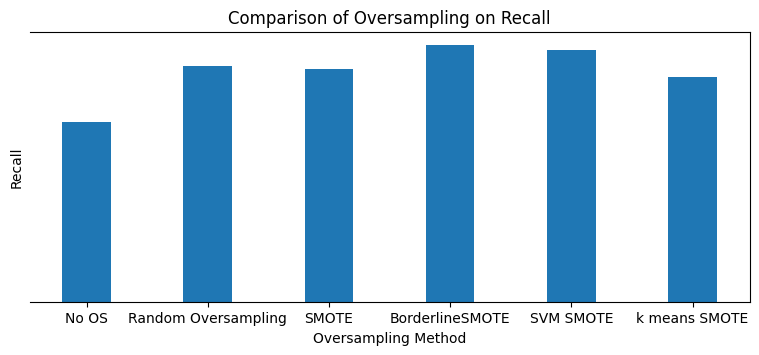

In [40]:
#Copying the results for graphing
versions = ['No OS', 'Random Oversampling', 'SMOTE', 'BorderlineSMOTE', 'SVM SMOTE', 'k means SMOTE']
recalls = [0.67, 0.88, 0.87, 0.96, 0.94, 0.84]

fig = plt.figure(figsize = (8,3))
ax = fig.add_axes([0,0,0.9,0.9])
plt.bar(x = versions, height = recalls, width = 0.4)
plt.title('Comparison of Oversampling on Recall')
ax.yaxis.set_ticks([])
ax.spines['left'].set_visible(False)
plt.xlabel('Oversampling Method')
plt.ylabel('Recall')

plt.show()

In terms of recall, BorderlineSMOTE performs best followed by SVM SMOTE.